# Cross validation example

Cross validation can provide a better estimate of performance than a single split of your dataset. We have often observed that running Glimr with a single split produces a configuration that is highly overfit to this validation dataset, and that generalizes poorly to independent testing data. Glimr provides tools to perform cross validation to address this.

When performing a cross validation, each model configuration is run in multiple trials with different cross-validation folds. Post experiment analysis can be used to identify the model configuration with the best average performance, or to build ensembles of models trained on different portions of the data.

Revisiting the MNIST example, we demonstrate the formulation of cross validation dataloaders and the experiment analysis tools.

## Create a cross validation data loader

Cross validation requires a dataloader that accepts `cv_index` and `cv_folds` arguments that represent the fold index and number of folds. The `Search` class will populate your data search space with these arguments automatically.

This data loader below uses stratified k-fold cross validation to build class-balanced folds. Since each trial will run a separate fold, random arguments like the split seed must be fixed across trials. 

In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf


def cv_dataloader(batch_size, random_brightness, max_delta, cv_index, cv_folds):
    """Cross-validation MNIST data loader.

    Parameters
    ----------
    batch_size : int
        The number of samples to batch.
    random_brightness : bool
        Whether to apply random brightness augmentation.
    max_delta : float
        The random brightness augmentation parameter.
    cv_index : int
        The index of the requested fold.
    cv_folds : int
        The number of folds in the cross validation.

    Returns
    -------
    train_ds : tf.data.Dataset
        A batched training set for fold `cv_index` used to build models.
    validation_ds : tf.data.Dataset.
        A batched validation set for fold `cv_index` used to evaluate models.
    """

    # load mnist data
    train, validation = tf.keras.datasets.mnist.load_data(path="mnist.npz")

    # combine training, validation sets
    merged = (
        np.concatenate((train[0], validation[0]), axis=0),
        np.concatenate((train[1], validation[1]), axis=0),
    )

    # flattening function
    def mnist_flat(features):
        return features.reshape(
            features.shape[0], features.shape[1] * features.shape[2]
        )

    # stratified k-fold cross validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=0)
    train_index, validation_index = [
        (i, o) for (i, o) in skf.split(merged[0], merged[1])
    ][cv_index]

    # extract features, labels
    train_features = tf.cast(mnist_flat(merged[0][train_index]), tf.float32) / 255.0
    train_labels = merged[1][train_index]
    validation_features = (
        tf.cast(mnist_flat(merged[0][validation_index]), tf.float32) / 255.0
    )
    validation_labels = merged[1][validation_index]

    # build datasets
    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_features, {"mnist": tf.one_hot(train_labels, 10)})
    )
    validation_ds = tf.data.Dataset.from_tensor_slices(
        (validation_features, {"mnist": tf.one_hot(validation_labels, 10)})
    )

    # batch
    train_ds = train_ds.shuffle(len(train_labels), reshuffle_each_iteration=True)
    train_ds = train_ds.batch(batch_size)
    validation_ds = validation_ds.batch(batch_size)

    # apply augmentation
    if random_brightness:
        train_ds = train_ds.map(
            lambda x, y: (tf.image.random_brightness(x, max_delta), y)
        )

    return train_ds, validation_ds

# Setting up the search space and model building funciton

The search space and model building function are not impacted by the choice to use cross validation. Reuse everything from the starter example.

In [2]:
from glimr.keras import keras_losses, keras_metrics
from glimr.optimization import optimization_space
from ray import tune


# layer 1 hyperparameters
activations = tune.choice(
    ["elu", "gelu", "linear", "relu", "selu", "sigmoid", "softplus"]
)
layer1 = {
    "activation": activations,
    "dropout": tune.quniform(0.0, 0.2, 0.05),
    "units": tune.choice([64, 48, 32, 16]),
}

# loss hyperparameters
loss = tune.choice(
    [
        {"name": "categorical_hinge", "loss": tf.keras.losses.CategoricalHinge},
        {
            "name": "categorical_crossentropy",
            "loss": tf.keras.losses.CategoricalCrossentropy,
        },
    ]
)

# metrics for reporting - fixed non-hyperparameters
metrics = {
    "name": "auc",
    "metric": tf.keras.metrics.AUC,
    "kwargs": {"from_logits": True},
}

# task layer hyperparameters
task = {
    "activation": activations,
    "dropout": tune.quniform(0.0, 0.2, 0.05),
    "units": 10,
    "loss": loss,
    "loss_weight": (1.0,),
    "metrics": metrics,
}

# optimizer search space
optimization = optimization_space()

# data loader keyword arguments to control loading, augmentation, and batching
data = {
    "batch_size": tune.choice([32, 64, 128]),
    "random_brightness": tune.choice(
        [True, False]
    ),  # whether to perform random brightness transformation
    "max_delta": tune.quniform(0.01, 0.15, 0.01),
}


# model builder function
def builder(config):
    def _build_layer(x, units, activation, dropout, name):
        x = tf.keras.layers.Dense(units, activation=activation, name=name)(x)
        if dropout > 0.0:
            x = tf.keras.layers.Dropout(dropout)(x)
        return x

    input_layer = tf.keras.Input([784], name="input")
    x = _build_layer(
        input_layer,
        config["layer1"]["units"],
        config["layer1"]["activation"],
        config["layer1"]["dropout"],
        "layer1",
    )
    task_name = list(config["tasks"].keys())[0]
    output = _build_layer(
        input_layer,
        config["tasks"][task_name]["units"],
        config["tasks"][task_name]["activation"],
        config["tasks"][task_name]["dropout"],
        task_name,
    )
    named = {f"{task_name}": output}
    model = tf.keras.Model(inputs=input_layer, outputs=named)
    losses, loss_weights = keras_losses(config)
    metrics = keras_metrics(config)

    return model, losses, loss_weights, metrics


# assemble the search space
space = {
    "layer1": layer1,
    "optimization": optimization_space(),
    "tasks": {"mnist": task},
    "data": data,
}

# Using Search with `cv_folds`

Creating a `Search` instance with the `cv_folds` argument is all that is needed to instruct `ray.tune` to perform a cross validation.

Since `cv_folds` trials will be run for each configuration, the total number of trials will be `cv_folds` * `num_samples`.

In [3]:
import contextlib
from glimr.search import Search
import os
import tempfile


# pass `cv_folds` parameter to Search for cross validation
tuner = Search(space, builder, cv_dataloader, "mnist_auc", cv_folds=5)

# make a temporary directory to store outputs - cleanup at end
temp_dir = tempfile.TemporaryDirectory()

# run trials using default settings
with contextlib.redirect_stderr(open(os.devnull, "w")):
    results = tuner.experiment(
        local_dir=temp_dir.name, name="cross_validation", num_samples=10
    )

2023-12-16 10:11:51,779	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'tasks/mnist/loss/loss': ('__ref_ph', '4ff9a407')}
2023-12-16 10:11:51,920	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'tasks/mnist/loss/loss': ('__ref_ph', '4ff9a407')}
2023-12-16 10:11:52,343	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'tasks/mnist/loss/loss': ('__ref_ph', '4ff9a407')}
2023-12-16 10:11:52,495	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'tasks/mnist/loss/loss': ('__ref_ph', '4ff9a407')}
2023-12-16 10:11:52,669	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'tasks/mnist/loss/loss': ('__ref_ph', '4ff9a407')}
2023-12-16 10:12:46,665	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to ten

## Create an experiment DataFrame for analysis

`glimr.analysis` contains functions for building Pandas DataFrames that contain trial information like performance, checkpoint location, and cross validation information. These DataFrames can be used for visualizaton or for analysis tasks like identifing the best performing checkpoints in each fold, or the configuration with the best average performance.

Text(0, 0.5, 'mnist_auc')

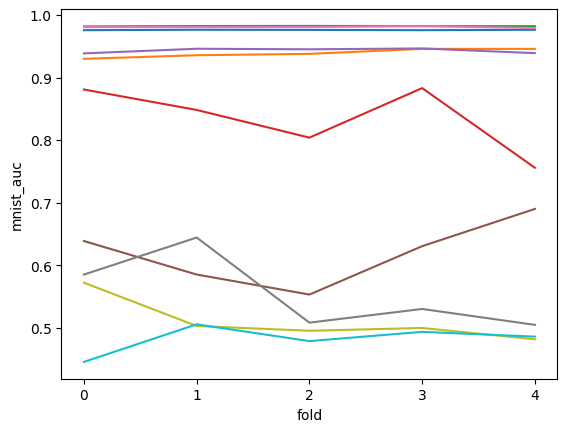

In [4]:
from glimr.analysis import default_checkpoints, experiment_table
import matplotlib.pyplot as plt


# create a dataframe of checkpointed epochs from all trials (folds + configurations)
exp_dir = temp_dir.name + "/cross_validation"
df = experiment_table(exp_dir, checkpointed=True)

# filter table to select checkpoints that correspond to best epoch
df = default_checkpoints(df)

# create parallel plot of config performance
performance = []
for enum in set(df["config_enum"]):
    config = df.loc[df["config_enum"]==enum, :].sort_values(by="cv_index")
    performance.append(np.array(config["mnist_auc"]))
fig, ax = plt.subplots(1, 1)
for config in performance:
    ax.plot(config)
plt.xlabel("fold")
plt.xticks(range(max(df["cv_index"]+1)))
plt.ylabel("mnist_auc")

## Experiment DataFrame queries

`glimr.analysis` contains functions to query the top performing trials or the configurations with the best performance over all folds.

In [6]:
from glimr.analysis import top_k_configs, top_k_trials

# the top 5 trials from all folds
top_k_trials(df, "mnist_auc", k=5, fold=None)

,index,trial_#,subdir,exp_dir,mnist_auc,mnist_loss,time_this_iter_s,should_checkpoint,done,training_iteration,...,time_total_s,pid,hostname,node_ip,config,time_since_restore,iterations_since_restore,checkpoint_path,cv_index,config_enum
0,11,2,"trainable_b3782_00002_2_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982645,0.265305,40.483688,True,True,4,...,158.567129,44600,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",158.567129,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,2,2
1,232,50,"trainable_b3782_00001_1_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982476,0.264139,40.380822,True,True,4,...,158.708772,44599,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",158.708772,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,1,2
2,196,40,"trainable_b3782_00003_3_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982383,0.268057,39.995779,True,True,4,...,161.585937,44601,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",161.585937,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,3,2
3,71,16,"trainable_b3782_00004_4_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982253,0.267615,40.535871,True,True,4,...,158.594500,44602,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",158.594500,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,4,2
4,202,42,"trainable_b3782_00048_48_batch_size=32,cv_inde...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982221,0.284125,31.209845,True,False,2,...,76.925258,44899,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'gelu', 'dropout': 0...",76.925258,2,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,3,6


In [8]:
# the configuration with the best median performance over all folds
top_k_configs(df, "mnist_auc", k=1, statistic=np.median)

,index,trial_#,subdir,exp_dir,mnist_auc,mnist_loss,time_this_iter_s,should_checkpoint,done,training_iteration,...,time_total_s,pid,hostname,node_ip,config,time_since_restore,iterations_since_restore,checkpoint_path,cv_index,config_enum
0,11,2,"trainable_b3782_00002_2_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982645,0.265305,40.483688,True,True,4,...,158.567129,44600,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",158.567129,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,2,2
1,232,50,"trainable_b3782_00001_1_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982476,0.264139,40.380822,True,True,4,...,158.708772,44599,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",158.708772,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,1,2
2,196,40,"trainable_b3782_00003_3_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982383,0.268057,39.995779,True,True,4,...,161.585937,44601,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",161.585937,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,3,2
3,71,16,"trainable_b3782_00004_4_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.982253,0.267615,40.535871,True,True,4,...,158.594500,44602,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",158.594500,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,4,2
5,63,14,"trainable_b3782_00000_0_batch_size=32,cv_index...",/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0.981891,0.272438,43.040012,True,True,4,...,164.773453,44598,FSMC07RG6YWKG,127.0.0.1,"{'layer1': {'activation': 'sigmoid', 'dropout'...",164.773453,4,/var/folders/tz/qttd962d27n1g_l3f83f9s95byzb9n...,0,2
